[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_1_Autoencoder_in_fMRI.ipynb)

In google colab, there are the things you will always have to do

---

# This script is to illustrate how supervised learning models decode fMRI data and their disadvantage of interpretation. And then we implement a simple unsupervised learning model (Restricted Bolzmann Machine) from scit-kit learning to illustrate the advantage of unsupervised learning and its interpretability.

# Spoiler alert, the results with RBM are really really really bad.




# $\bullet$ How much information is learned by the machine learning models?
## Measured by the decoding accuracy (*using an independent test data*). Higher accuracy, more information is learned


# $\bullet$ How much information that is learned by the machine learning models of the current data can be generalized to new data?
## Measured by generalization accuracy. Higher accuracy, more information can be generalized. 


# $\bullet$ What is learned by the machine learning models?
## Measured by the learned representations of the model. 
###For supervised ML, use using [Haufe's trick](https://www.sciencedirect.com/science/article/pii/S1053811913010914?via%3Dihub): $$A = \text{Cov}_X \cdot \text{Weights} \cdot \text{Precision}_Y$$the last term $\text{Precision}_Y$ [is 1 when doing binary classification](https://github.com/mne-tools/mne-python/blob/maint/0.16/mne/decoding/base.py#L96-L103)
### For unsupervised ML, take a look at the transformed data.

# Assumption of learned representation:

## In a latent space that contains N length vectorized representation, each coordinated vector value corresponds to one disentanglable features contained in the input data

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score




Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 1s (770 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...
Un

In [2]:
from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful but I recommend you never use this
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization # the most important functions for neural networks
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose # never mind, we will use selu
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard # for model performance estimation
from keras import regularizers # regularizers for the model parameters and outputs
from sklearn import metrics # somewhat less important
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold



Using TensorFlow backend.


In [0]:
import seaborn as sns
sns.set_context('poster') # automatically make the figures look good
sns.set_style('whitegrid') # the clean background
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# extract the data from google drive to the working memory here
data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

# Read condition

## Experiment:

## Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

## Since I don't speak Spanish, I use a trained Word2Vec model to transform the words into 300-length vector representations, and then compute the dissimilarity matrix among them. I will talk about the Word2Vec model specifically later

In [0]:
from IPython.display import Image
image_id = 'https://drive.google.com/open?id=1qZfXGiqtQ9g5DJsCtb_Injy_tSCEJ3dG'.split('id=')[-1]
image = drive.CreateFile({'id':image_id})
image.GetContentFile('{}'.format('words.png'))


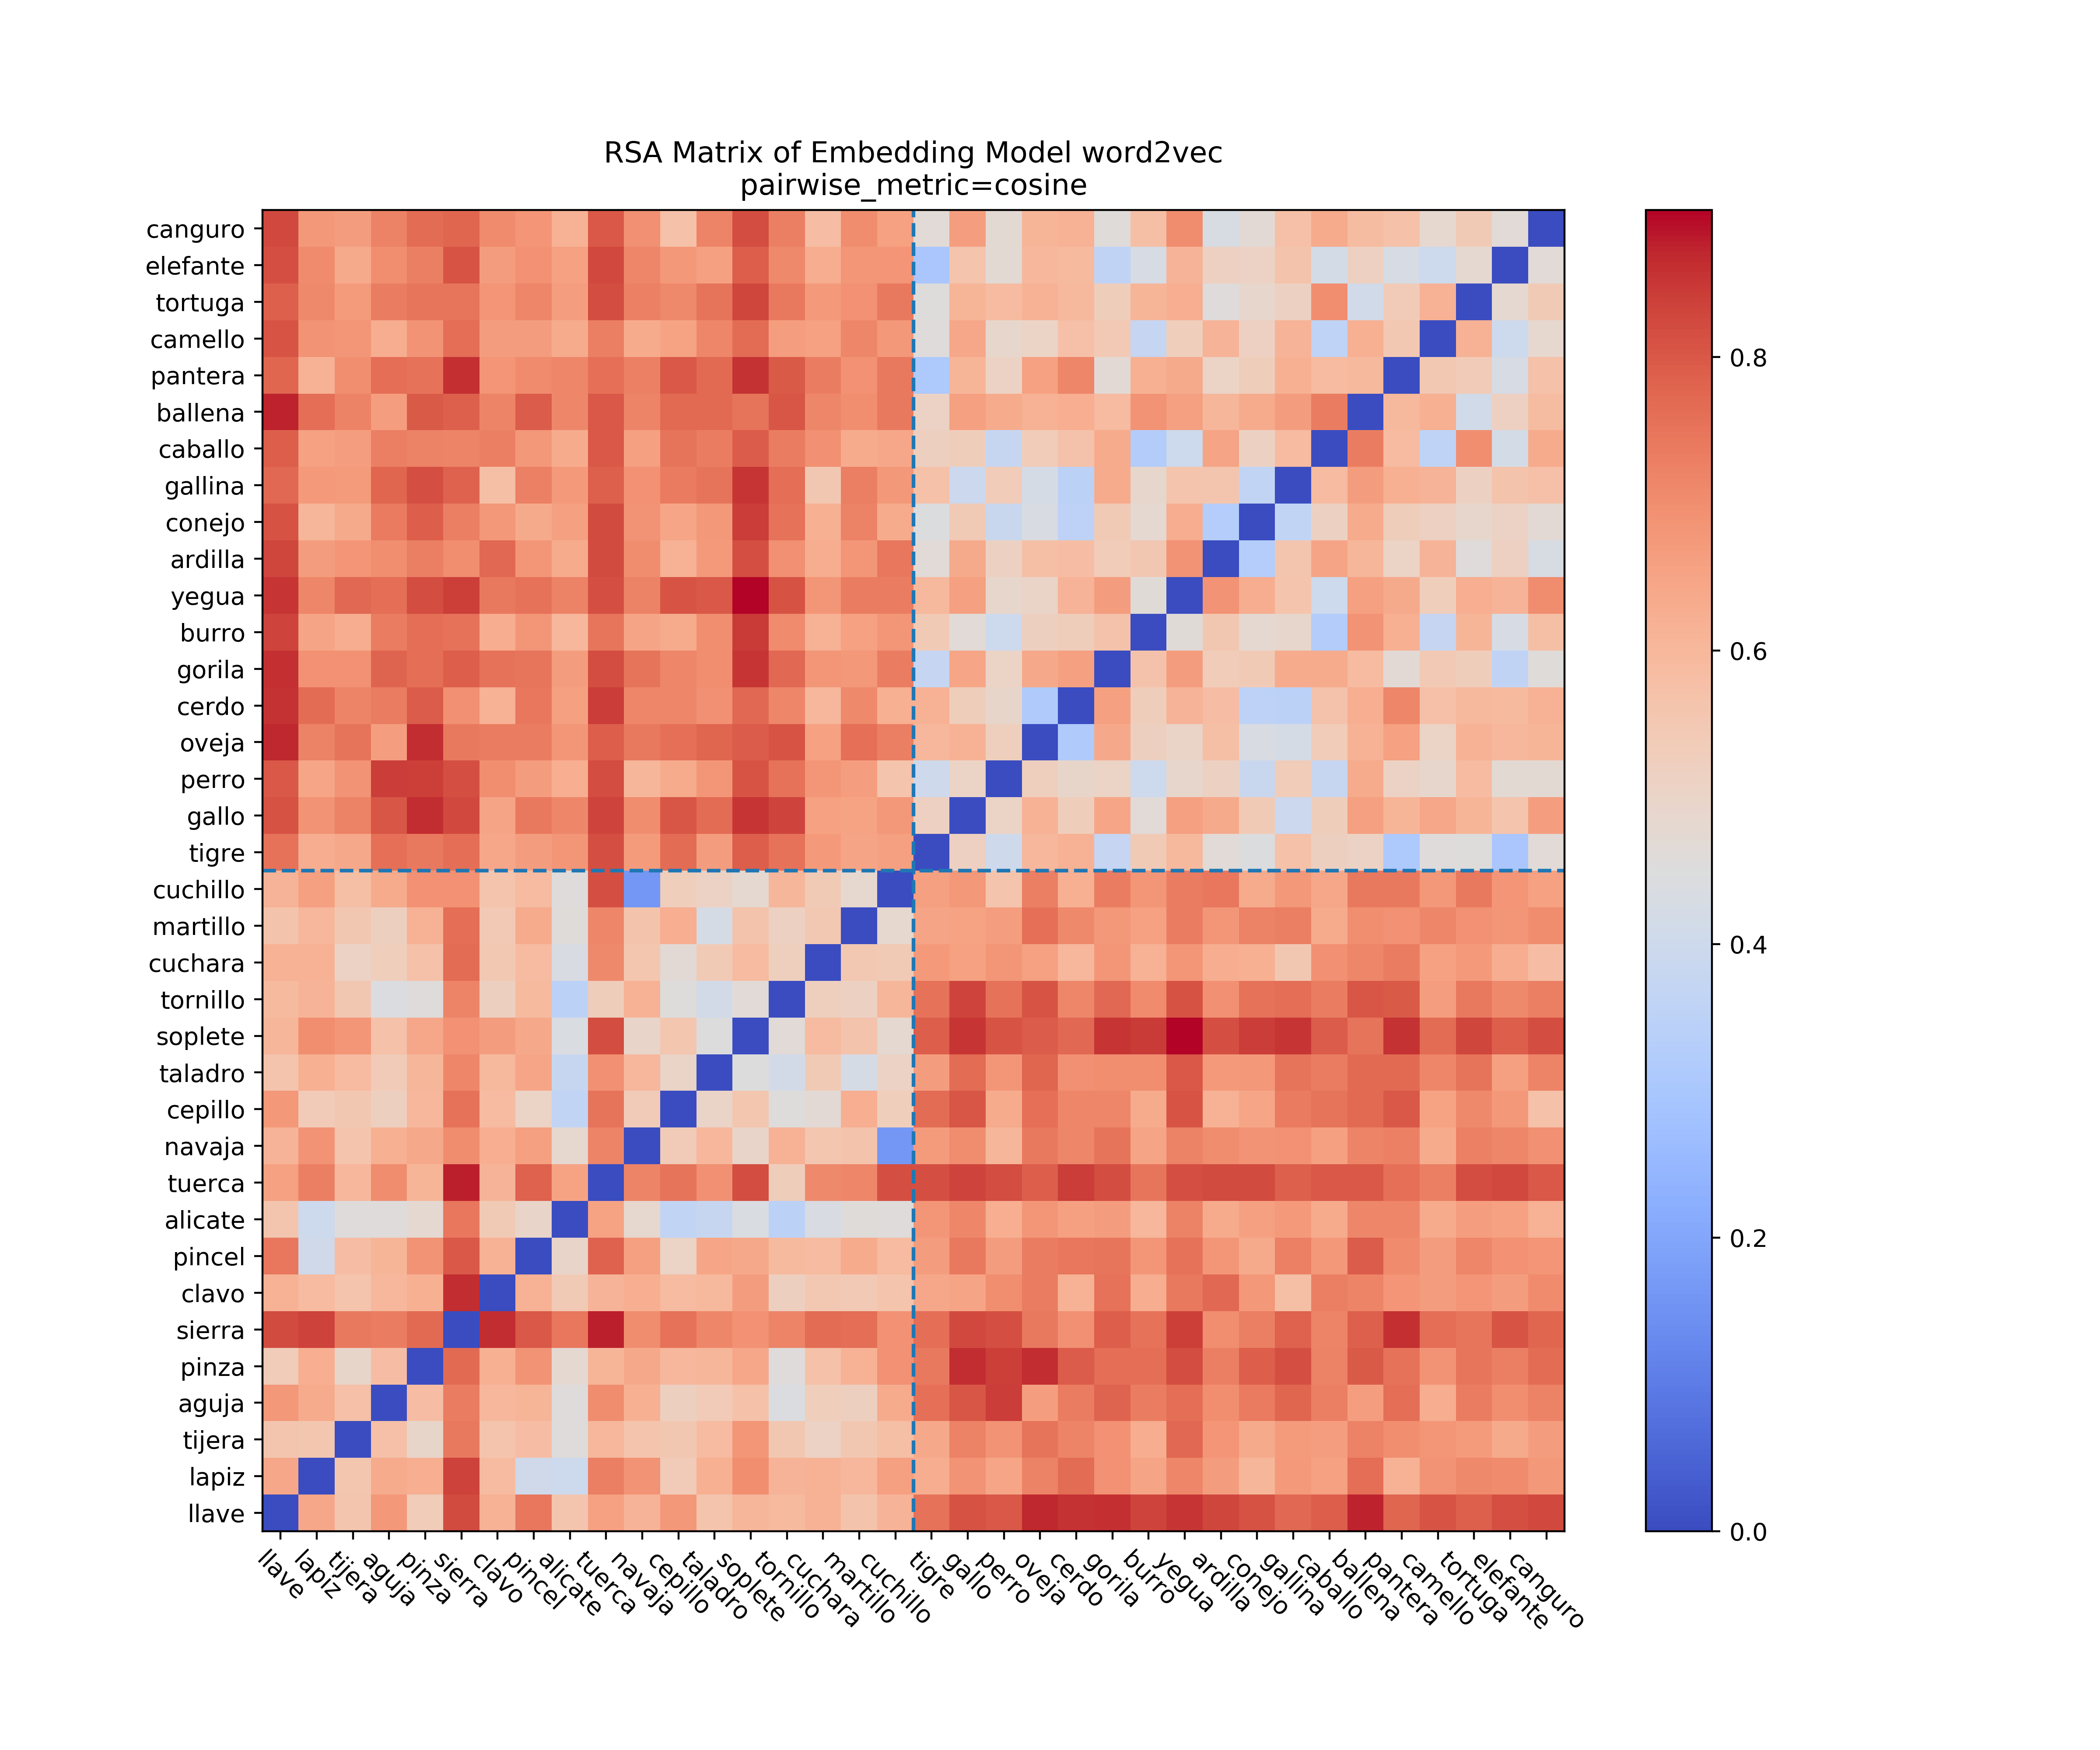

In [5]:
Image('words.png',height=700)

In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [7]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

# Baseline Supervised Machine Learning Method: PCA + SVM

## [ask for reference: why is this the common baseline?]()

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import (classification_report,
                             matthews_corrcoef,
                             confusion_matrix,
                             f1_score,
                             log_loss)



In [0]:
# helper funtion
def get_blocks_metasema(dataset__,label_map):
    """
    # use ids, chunks,and labels to make unique blocks of the pre-average dataset, because I don't want to 
    # average the dataset until I actually want to, but at the same time, I want to balance the data for 
    # both the training and test set.
    
    Preparation for cross validation functions used in scit-kit learning
    """
    ids                 = dataset__.sa.id.astype(int)
    chunks              = dataset__.sa.chunks
    labels              = np.array([label_map[item] for item in dataset__.targets])[:,-1]
    sample_indecies     = np.arange(len(labels))
    blocks              = [np.array([ids[ids             == target],
                                     chunks[ids          == target], 
                                     labels[ids          == target],
                                     sample_indecies[ids == target]
                                     ]) for target in np.unique(ids)]
    block_labels        = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
    return blocks,block_labels


In [0]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold         = roc_curve(target, predicted)
    i                           = np.arange(len(tpr)) 
    roc                         = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t                       = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Baseline line model cross validation work flow (not going to details)

In [11]:
average = True # average the instances before training the baseline model

scores = []
cfm    = []
weight = []
label_map = dict(animal  = [0,1],
                 tool    = [1,0])
blocks, block_labels = get_blocks_metasema(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits     = 30,# random partition 30 times, but ideally, we need 100 or more
                            test_size    = 0.2, # 20 % as the test data
                            random_state = 12345 # for reproducibility purpose
                           )
for fold, (train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_element][-1] for tr_element in train])
    idx_test  = np.concatenate([blocks[te_element][-1] for te_element in test ])
    ###########  initialize the pipeline for each fold #####################
    baseline = make_pipeline(MinMaxScaler(),# range data between 0 and 1 - for fair comparison to other deep learning models
                             PCA(),
                             SVC(kernel       = 'linear',# linear SVM
                                 probability  = True, # I like to estimate a probability of the predictions
                                 random_state = 12345, # for reproducibility purpose
                           )
                       )
    ##############################################################################
    
    
    # select the training and testing split again to make sure we do the right cv
    tr                    = dataset[idx_train]
    te                    = dataset[idx_test]
    # average the train data for baseline to improve the signal to noise ratio
    if average:
        tr                = tr.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    
    X_train               = tr.samples.astype('float32')
    # one-hot the labels, but use the last column
    y_train               = np.array([label_map[item] for item in tr.targets])[:,-1]
    baseline.fit(X_train,y_train)
    # average the test data for the baseline model
    te                    = te.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    # transform the test labels as well
    y_test                = np.array([label_map[item] for item in te.targets])[:,-1]
    # make the probabilistic prediction
    pred_                 = baseline.predict_proba(te.samples.astype('float32'))[:,-1]
    # find the optimal cut-off probability in the roc curve
    score_baseline1       = roc_auc_score(y_test,pred_) # ROC AUC score: how separatable between the 2 classes
    threshold_            = Find_Optimal_Cutoff(y_test,pred_)[0]
    score_baseline2       = matthews_corrcoef(y_test,pred_>threshold_) # MCC: conservative
    score_baseline3       = f1_score(y_test,pred_>threshold_) # f1 score, based on precision and recall, biased to positive class
    score_baseline4       = log_loss(y_test,baseline.predict_proba(te.samples.astype('float32')))# an unbiased metric, but hard to interpret
    tn, fp, fn, tp        = confusion_matrix(y_test,pred_>threshold_).ravel()# unbiased metric, but hard to plot in complex experiments like this with multiple factors
    print('fold {}'.format(fold + 1))
    print(classification_report(y_test,pred_>threshold_))
    scores.append([score_baseline1,score_baseline2,score_baseline3,score_baseline4])
    cfm.append(   [tn,fp,fn,tp])
    weight.append(baseline.get_params()['steps'][-1][-1].coef_)

 * Please note: warnings are printed only once, but underlying problem might occur many times *
fold 1
             precision    recall  f1-score   support

          0       0.54      0.54      0.54        26
          1       0.52      0.52      0.52        25

avg / total       0.53      0.53      0.53        51

fold 2
             precision    recall  f1-score   support

          0       0.57      0.62      0.59        26
          1       0.57      0.52      0.54        25

avg / total       0.57      0.57      0.57        51

fold 3
             precision    recall  f1-score   support

          0       0.62      0.62      0.62        26
          1       0.60      0.60      0.60        25

avg / total       0.61      0.61      0.61        51

fold 4
             precision    recall  f1-score   support

          0       0.54      0.58      0.56        26
          1       0.52      0.48      0.50        25

avg / total       0.53      0.53      0.53        51

fold 5
         

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)
weight = np.array(weight)

In [13]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.633 +/- 0.064
f1 score = 0.576 +/- 0.063


ROC AUC score measures how seperateable between the 2 classes, aka how much information can be decoded

F1 score measures how sensitive the decoder to decodable information with respect to each class

In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])


/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Baseline Model')]

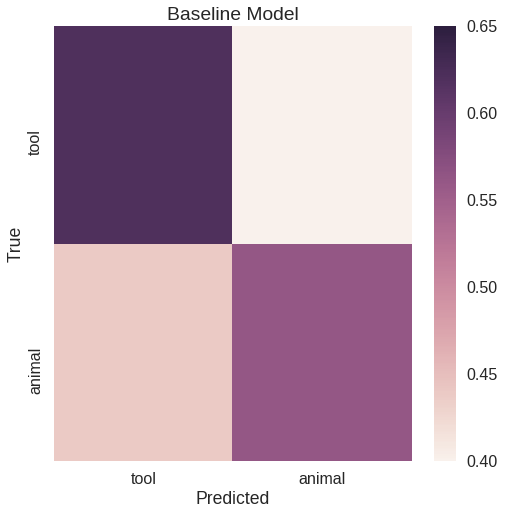

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax,vmin=0.4,vmax=0.65)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Baseline Model')

# Another baseline using Randomforest

## Scaler  + RandomForest + SVM

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
average = True # average the instances before training the baseline model

scores = []
cfm    = []
weight = []
label_map = dict(animal  = [0,1],
                 tool    = [1,0])
blocks, block_labels = get_blocks_metasema(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits     = 30,# random partition 30 times, but ideally, we need 100 or more
                            test_size    = 0.2, # 20 % as the test data
                            random_state = 12345 # for reproducibility purpose
                           )
for fold, (train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_element][-1] for tr_element in train])
    idx_test  = np.concatenate([blocks[te_element][-1] for te_element in test ])
    ###########  initialize the pipeline for each fold #####################
    baseline = make_pipeline(MinMaxScaler(),# range data between 0 and 1 - for fair comparison to other deep learning models
                             SelectFromModel(RandomForestClassifier(n_estimators    = 200, # 200 trees not control for model complexity, which might not be good
                                                random_state    = 12345
                                                ),
                        prefit                                  = False
                                                  ),
                             SVC(kernel='linear',probability=True,random_state=12345)
                           )
                       
    ##############################################################################
    
    
    # select the training and testing split again to make sure we do the right cv
    tr                    = dataset[idx_train]
    te                    = dataset[idx_test]
    # average the train data for baseline to improve the signal to noise ratio
    if average:
        tr                = tr.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    
    X_train               = tr.samples.astype('float32')
    # one-hot the labels, but use the last column
    y_train               = np.array([label_map[item] for item in tr.targets])[:,-1]
    baseline.fit(X_train,y_train)
    # average the test data for the baseline model
    te                    = te.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    # transform the test labels as well
    y_test                = np.array([label_map[item] for item in te.targets])[:,-1]
    # make the probabilistic prediction
    pred_                 = baseline.predict_proba(te.samples.astype('float32'))[:,-1]
    # find the optimal cut-off probability in the roc curve
    score_baseline1       = roc_auc_score(y_test,pred_)
    threshold_            = Find_Optimal_Cutoff(y_test,pred_)[0]
    score_baseline2       = matthews_corrcoef(y_test,pred_>threshold_) # MCC: conservative
    score_baseline3       = f1_score(y_test,pred_>threshold_) # f1 score, based on precision and recall, biased to positive class
    score_baseline4       = log_loss(y_test,baseline.predict_proba(te.samples.astype('float32')))# an unbiased metric, but hard to interpret
    tn, fp, fn, tp        = confusion_matrix(y_test,pred_>threshold_).ravel()# unbiased metric, but hard to plot in complex experiments like this with multiple factors
    print('fold {}'.format(fold + 1))
    print(classification_report(y_test,pred_>threshold_))
    scores.append([score_baseline1,score_baseline2,score_baseline3,score_baseline4])
    cfm.append(   [tn,fp,fn,tp])
    #weight.append(baseline.get_params()['steps'][-1][-1].coef_)

fold 1
             precision    recall  f1-score   support

          0       0.52      0.54      0.53        26
          1       0.50      0.48      0.49        25

avg / total       0.51      0.51      0.51        51

fold 2
             precision    recall  f1-score   support

          0       0.48      0.50      0.49        26
          1       0.46      0.44      0.45        25

avg / total       0.47      0.47      0.47        51

fold 3
             precision    recall  f1-score   support

          0       0.58      0.58      0.58        26
          1       0.56      0.56      0.56        25

avg / total       0.57      0.57      0.57        51

fold 4
             precision    recall  f1-score   support

          0       0.63      0.65      0.64        26
          1       0.62      0.60      0.61        25

avg / total       0.63      0.63      0.63        51

fold 5
             precision    recall  f1-score   support

          0       0.46      0.48      0.47        2

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [18]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.623 +/- 0.059
f1 score = 0.563 +/- 0.066


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])


[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Random Forest')]

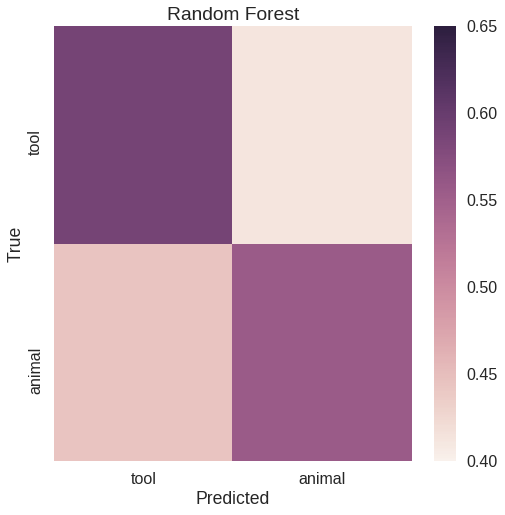

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax,vmin=0.4,vmax=0.65)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Random Forest')

# The problem I want to approach is: what have these machine learning model learned?
Of course, it is okay to stop here if we use the machine learning models as a black box. But I want to know what a machine learning has learned, so that I can compare across different model with repect to what the learned representations/features/voxels are.

1. representation: how the machine learning model disentangles/dislineates the input data
2. features: how the machine learning model decides the relevant features
3. voxels: when the features are only voxels, how the machine learning model selects the features to form the decision function

## Clearly, it it not intuitive to see weights of the SVM model because it takes the PCAed data: (201,16000) $\rightarrow$ (201,201), and the inverse transform is not helpful
## On the other hand, the RandomForest provided the feature importance ranking and used it to threholding the feature selection, so that the nested SVM worked with the subset of the voxels. To work backwards using the [Haufe trick](https://colab.research.google.com/drive/1QEgAlvhIBLlMS6SCcwagey3BIIEjKGYC#scrollTo=JFlvdIdSTHIK&line=4&uniqifier=1) is conceptually difficult.

# Thus, unsupervised mapping techniques are more ideal and straightforward in these situations.


# First of all what is an Autoencoder (An Implicit Generative Model, 1989)

## what is an encoder?
## what is an decoder?

### Computer Science terminology:
1. encoder: a function that maps inputs to a learnable representation
$$P(z | x)$$
<br /> the prob of a set latent representation given the input data
2. decoder: a function that maps the learnable representation and a reconstructed inputs
$$q(\hat{x} | z)$$
<br />the prob of the reconstruct data given a set of latent representation
3. autoencoder: the pipeline that connects an encoder with a decoder
$$q(\hat{x} |z,P(z),x)$$

# Simplest autoencoder

In [21]:
Image(url = 'https://www.alanzucconi.com/wp-content/uploads/2018/02/nn_04.png',height=300)

# Simplest autoencoder from a different perspective (Bolzmann machine)

In [22]:
Image(url = 'https://openi.nlm.nih.gov/imgs/512/76/3902207/PMC3902207_fncom-07-00195-g0002.png',height=300
     )

# [Animated perspective](https://towardsdatascience.com/@maxfrenzel)

In [23]:
Image(url = 'https://cdn-images-1.medium.com/max/800/1*TmemxxQxMvNwCnbmnBZtLQ.jpeg',height=340)

# [Restricted Boltzmann Machine](http://stanford.edu/~jlmcc/papers/PDP/Volume%201/Chap6_PDP86.pdf)

[Hinton and Salakhutdinov, 2006](http://www.cs.toronto.edu/~hinton/science.pdf)

[Asja and Igel, 2014](https://www.semanticscholar.org/paper/Training-restricted-Boltzmann-machines%3A-An-Fischer-Igel/e1a1c3d3e0336d6bfc48fd480a9d18a4f92edc60)

In [24]:
Image(url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/e1a1c3d3e0336d6bfc48fd480a9d18a4f92edc60/2-Figure1-1.png',
     height=350)

In [25]:
Image(url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/e1a1c3d3e0336d6bfc48fd480a9d18a4f92edc60/3-Figure2-1.png',
     height=350)

# [Denoising Autoencoder](http://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf)

## basically, mapping signal+noise to signal

In [26]:
Image(url = 'https://www.researchgate.net/profile/Varun_Kumar32/publication/272086159/figure/fig2/AS:573504648998912@1513745571839/Denoising-Autoencoder.jpg',
     height=350)

the noise added is Gaussian noise we on purposely add to the preprocessed fMRI data. Thus, the autoencoder should be able to, and only able to, reduce the Gaussian noise from the corrupted input, hope the removal of the noise brings insights about the latent structuer of the data.

However, the idea that adding some noise to the input data is a good idea, and [we will talk about that theoretically later if we have time](https://arxiv.org/pdf/1805.00932.pdf).

# [Sparse Autoencoder](https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf)

## A very useful tool in natural language processing because it explicitly extracts features and seperates by nodes (ideally, regularization techniques require), however, it is not as easy as I thought it would be to implment via tensorflow. Because it requires an explicit adding of the regularization loss to the total loss, which can be a mess when I lose track of the loss function and which layer I want to implement the regularization

[Anant et al., 2017](https://arxiv.org/pdf/1711.08792.pdf)

Recomemd: Why Does Unsupervised Pre-training Help Deep Learning?
<br />[Dumitru et al., 2010](http://jmlr.org/papers/volume11/erhan10a/erhan10a.pdf)
<br />[Markhzani and Frey, k-sparse autoencoder](https://arxiv.org/pdf/1312.5663.pdf)

In [27]:
Image(url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/b94043a133e3d07ed0b1cfc036829e619ea0ba22/6-Figure2-1.png',height=300)

# [Word2Vec models](https://www.youtube.com/watch?v=25nC0n9ERq4)

## [Pin2vec](https://medium.com/the-graph/applying-deep-learning-to-related-pins-a6fee3c92f5e)

##[why DNN is not necessarily better than SVM](http://www.fast.ai/2018/04/29/categorical-embeddings/)

1. It is a local association model
1. contrast to [Bengio et al., 2003](http://web2.cs.columbia.edu/~blei/seminar/2016_discrete_data/readings/BengioDucharmeVincentJanvin2003.pdf)
2. it contrast to [Collobert and Weston, 2008](http://www.cs.columbia.edu/~smaskey/CS6998-Fall2012/supportmaterial/colbert_dbn_nlp.pdf), look up table
3. forgo the costly hidden layer
4. allow the model to tak additional context into account
5. depends on training strategies $\left\{\begin{array}\l{}\text{continuous bag-of-words (CBOW): surronding words predicts center word}\\\text{skip-gram} : \text{center word predicts surrounding word}\end{array}\right.$
6. it is a predictive model: predictive models learn their vectors to improve predictive ability of Loss(target | context word; vec)

In [28]:
Image(url = 'https://cdn-images-1.medium.com/max/800/0*9FzQNAY1sCgqV9Hk.png')

In [29]:
Image(url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/34aec4d172f59c1ffe32f3afe3bf4ffc5cd7559a/2-Figure1-1.png',
     height=350)

The point here is that by variating the input and output for a simple 1-hidden-layer autoencoder, you can map outputs that are different from the input and learn about their relationship

# [Variational Autoencoder](https://arxiv.org/pdf/1312.6114.pdf)

## Adding Bayesian inference to autoencoder, which is a strong prior of how the network should learn



# The propurse of adding uncertainty:

1. find a common latent distribution to represent one latent/learnable feature from the raw data
2. find the relative among of uncertainty so that it becomes easier to generalize to new data
3. to get a better understand how each learned latent resentative feature overlaps each other

In [30]:
Image(url = 'https://cdn-images-1.medium.com/max/800/1*s7xztc7oz_l6dG7OHHoVKQ.jpeg',
     height=350)

# Let's focus on only the Bayesian inference layer

In [31]:
Image(url = 'https://image.slidesharecdn.com/variationalautoencoder-160616085558/95/variational-autoencoder-10-1024.jpg?cb=1468290546',
     height = 300)

The dash lines are the paths of the encoder, where the firm lines are the paths of the decoder
1. With the parameter $\phi$, function $q$ learns a representation $z$ from $x$ (input)
2. With the parameter $\theta$, function $p$ learns to construct $\hat{x}$ from $z$
3. There is no way to compute the posterior function $p_{\theta}(z|x)$ but to approxiate it via $q_{\phi}(z|x)$
4. Thus, the objective of the VAE model is to minize the KL divergence between function $p_{\theta}(z|x)$ and $q_{\phi}(z|x)$
5. $q_{\phi}(z|x)$ can be learned via the reconstruction loss

# The so-called reparameterized trick
$$p_{\theta}(x|z) \approx \mathcal{N}(\mu_z|x, \Sigma_z|x)$$
$$\mu_z|x, \Sigma_z|x = q_{\phi}(z|x)$$

In [32]:
Image(url = 'http://bjlkeng.github.io/images/variational_autoencoder3.png',height=400)

$$Loss = Reconstruction + KL$$
$$Loss = E[X,\hat{X}] + KL(q,p)$$

# The way I visualize the model

In [33]:
Image(url = 'https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-12.24.19-AM.png',height=300)

# The so-called reparameterization trick:

1. we want to have a function $q_{\theta}(\hat{x}|z)$ that is close to $p_{\phi}(z|x)$
2. the reason we do so is because we cannot derive a function $q_{\theta}(z|\hat{x})$


1. start from the decoder: find a function $q_{\theta}(\hat{x}|z)$
2. but where is $z$?
3. $z$ is from $p_{\phi}(z|x)$, which should have been from $q_{\theta}(z|\hat{x})$, because $$q_{\theta}(\hat{x}|z) \propto q_{\theta}(z|\hat{x})\text{prior}(\hat{x})$$
4. it is quite impossible (still probable) to derive the function $q_{\theta}(z|\hat{x})$, so we want to approxiate this function from a deterministic function $p_{\phi}(z|x)$

In [34]:
Image(url = 'https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.36.34-PM.png')

1. deterministic: the value is determined by its upstream variable (aka it is a dependent variable)
2. random: also called stochastic , the value is not determined by any other variables within the model (aka it is an indepedent variable within the model)
3. left: $q(z|x)$ is not learnable 
4. right: subsitute random node $z$ by a deterministic node so that the gradients can pass through from output to input

# How $\beta$ controls the learning of the latent representations

In [35]:
Image(url = 'https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.51.06-PM.png',height=350)

# [Beta-Variational Autoencoder](https://openreview.net/pdf?id=Sy2fzU9gl)

$$Loss = \text{Reconstruction} + KL$$
$$Loss = E[X,\hat{X}] + \mathbf{\beta} * KL(q,p)$$
$$\text{where }\beta \neq 1$$

In [36]:
Image(url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/99ca6b23e2e2e52d4de4068608adce98e281c1ab/5-Figure2-1.png',
     height=300)

# Implementing some of the mdoels to fMRI decoding

## [Restricted Boltzmann Machines (Scit-kit learning)](https://colab.research.google.com/drive/1QEgAlvhIBLlMS6SCcwagey3BIIEjKGYC#scrollTo=WCh2yCehKmy1)

1. MinMax scale $\rightarrow$ values range between 0 to 1
2. thresholding to make the feature values to a binary representation, due to the sklearn RBM takes binary input values better than continuous values. If you want to implement the normal RBM, use tensorflow, and protentially, you can make a deep belief machine, which is a stacked of multiple RMBs
3. add RMB as a feature selector
4. a linear SVM estimator

In [37]:
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import Binarizer
from sklearn.feature_selection import SelectFromModel

label_map = dict(animal  = [0,1],
                 tool    = [1,0])
blocks, block_labels = get_blocks_metasema(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits     = 30,# random partition 30 times, but ideally, we need 100 or more
                            test_size    = 0.2, # 20 % as the test data
                            random_state = 12345 # for reproducibility purpose
                           )
scores = []
cfm    = []
weight = []
average = True

for fold, (train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_element][-1] for tr_element in train])
    idx_test  = np.concatenate([blocks[te_element][-1] for te_element in test ])
    
    SVM = SVC(kernel                        = 'linear',
            random_state                    = 12345,
            probability                     = True
            )
    RBM = BernoulliRBM(
                 n_components           = 256, # transform data to 256 vector length
                 learning_rate          = 1e-3,# learning rate
                 batch_size             = 16,
                 n_iter                 = int(25), # for time sake
                 random_state           = 12345,
                 verbose                = False)
    pipeline = make_pipeline(MinMaxScaler(),
                             Binarizer(threshold = 0.5),
                             RBM,
                             SVM)
    # select the training and testing split again to make sure we do the right cv
    tr                    = dataset[idx_train]
    te                    = dataset[idx_test]
    # average the train data for baseline to improve the signal to noise ratio
    if average:
        tr                    = tr.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    
    X_train               = tr.samples.astype('float32')
    # one-hot the labels, but use the last column
    y_train               = np.array([label_map[item] for item in tr.targets])[:,-1]
    pipeline.fit(X_train,y_train)
    # average the test data for the baseline model
    te                    = te.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))
    # transform the test labels as well
    y_test                = np.array([label_map[item] for item in te.targets])[:,-1]
    
    pred_                 = pipeline.predict_proba(te.samples.astype('float32'))[:,-1]
    score_RBM1            = roc_auc_score(y_test,pred_)
    threshold_            = Find_Optimal_Cutoff(y_test,pred_)[0]
    score_RBM2            = matthews_corrcoef(y_test,pred_>threshold_)
    score_RBM3            = f1_score(y_test,pred_>threshold_)
    score_RBM4            = log_loss(y_test,pipeline.predict_proba(te.samples.astype('float32')))
    tn, fp, fn, tp        = confusion_matrix(y_test,pred_>threshold_).ravel()
    print('fold {}'.format(fold + 1))
    print(classification_report(y_test,pred_>threshold_))
    scores.append([score_RBM1,score_RBM2,score_RBM3,score_RBM4])
    cfm.append(   [tn,fp,fn,tp])
    weight.append(pipeline.get_params()['steps'][-1][-1].coef_)

fold 1
             precision    recall  f1-score   support

          0       0.52      0.62      0.56        26
          1       0.50      0.40      0.44        25

avg / total       0.51      0.51      0.50        51

fold 2
             precision    recall  f1-score   support

          0       0.55      0.69      0.61        26
          1       0.56      0.40      0.47        25

avg / total       0.55      0.55      0.54        51

fold 3
             precision    recall  f1-score   support

          0       0.55      0.62      0.58        26
          1       0.55      0.48      0.51        25

avg / total       0.55      0.55      0.55        51

fold 4
             precision    recall  f1-score   support

          0       0.48      0.50      0.49        26
          1       0.46      0.44      0.45        25

avg / total       0.47      0.47      0.47        51

fold 5
             precision    recall  f1-score   support

          0       0.50      0.52      0.51        2

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fold 27
             precision    recall  f1-score   support

          0       0.51      1.00      0.68        26
          1       0.00      0.00      0.00        25

avg / total       0.26      0.51      0.34        51

fold 28
             precision    recall  f1-score   support

          0       0.50      0.50      0.50        26
          1       0.48      0.48      0.48        25

avg / total       0.49      0.49      0.49        51

fold 29
             precision    recall  f1-score   support

          0       0.50      0.62      0.55        26
          1       0.47      0.36      0.41        25

avg / total       0.49      0.49      0.48        51

fold 30
             precision    recall  f1-score   support

          0       0.50      0.50      0.50        26
          1       0.48      0.48      0.48        25

avg / total       0.49      0.49      0.49        51



In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)
weight = np.array(weight)

In [39]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.503 +/- 0.068
f1 score = 0.449 +/- 0.115


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Restricted Boltzmann Machine Model')]

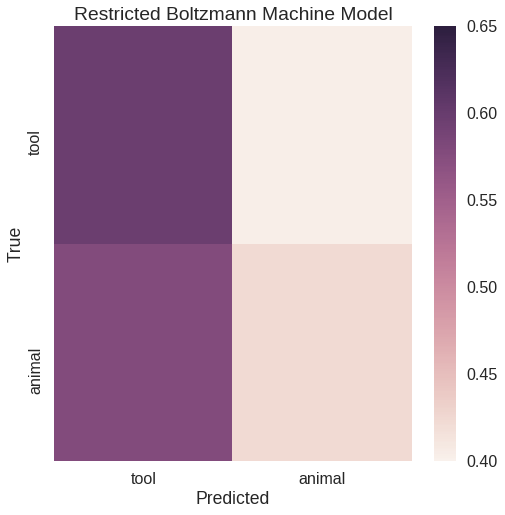

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax,vmin=0.4,vmax=0.65)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Restricted Boltzmann Machine Model')

In [0]:
#Image(url = 'https://cdn-images-1.medium.com/max/600/1*WR3dOULWegRxm4EddXyuSQ.jpeg')

In [43]:
SVM = SVC(kernel                        = 'linear',
        random_state                    = 12345,
        probability                     = True
        )
RBM = BernoulliRBM(
             n_components           = 256, # transform data to 256 vector length
             learning_rate          = 1e-3,# learning rate
             batch_size             = 16,
             n_iter                 = int(25), # for time sake
             random_state           = 12345,
             verbose                = False)
pipeline = make_pipeline(MinMaxScaler(),
                         Binarizer(),
                         RBM,
                         SVM)
X = dataset.samples
y = np.array([label_map[item] for item in dataset.sa.targets])[:,-1]
X.shape,y.shape

((1544, 16130), (1544,))

In [44]:
pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('binarizer', Binarizer(copy=True, threshold=0.0)), ('bernoullirbm', BernoulliRBM(batch_size=16, learning_rate=0.001, n_components=256, n_iter=25,
       random_state=12345, verbose=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=12345, shrinking=True,
  tol=0.001, verbose=False))])

In [45]:
weights = pipeline.get_params()['steps'][2][-1]
weights.components_.shape

(256, 16130)

# One way to interpret the weight matrix is pass the impluse input ([1,0,0,0,...,0,0,0]) to the weights and visualize the output (16130 dimension), and it will take some time since there are 256 of the inpluses for visualization

https://plot.ly/scikit-learn/plot-rbm-logistic-classification/

[interpretation by Geoffrey Hinton](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

# Or we can directly sample from the RBM and compare the results with the data

In [0]:
animal = Binarizer(threshold=0.5,).fit_transform(MinMaxScaler().fit_transform(dataset[dataset.sa.targets == 'animal'].samples.astype('float32')))
tool   = Binarizer(threshold=0.5,).fit_transform(MinMaxScaler().fit_transform(dataset[dataset.sa.targets == 'tool'].samples.astype('float32')))

In [0]:
animal_sample = weights.gibbs(animal)
tool_sample   = weights.gibbs(tool)

In [0]:
from sklearn.utils import shuffle

In [0]:
sampled_data = np.concatenate([animal_sample,tool_sample])
sampled_labels = np.concatenate([[1]*len(animal),[0]*len(tool)])
sampled_data,sampled_labels = shuffle(sampled_data,sampled_labels)

In [73]:
prds = pipeline.predict(sampled_data)
score1 = roc_auc_score(sampled_labels,prds)
score2 = f1_score(sampled_labels,prds)
print('ROC AUC score = {:.3f}, F1 score = {:.3f}'.format(score1,score2))

ROC AUC score = 0.500, F1 score = 0.000


In [0]:
from matplotlib import pyplot as plt
from math import pi

In [0]:
animal_ = weights.transform(animal)
tool_   = weights.transform(tool)
sample_data = np.concatenate([animal_,tool_])
sample_labels = np.concatenate([[1] * len(animal), [0]*len(tool)])

In [0]:
N = 256
angles = [n / float(N) * 2. * pi for n in range(N)]
angles += angles[:1]

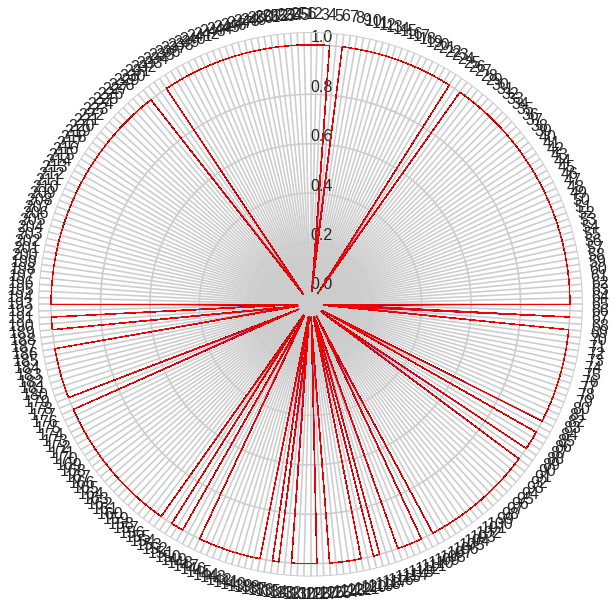

In [78]:
color = ['red','blue']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,polar = True)
_=ax.set_theta_offset(pi / 2)
_=ax.set_theta_direction(-1)

_=ax.set(xticks = angles[:-1],xticklabels=['{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(sample_data,sample_labels):
    values = list(row)
    values += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.2,color=color[label])